In [56]:
!pip install datasets

In [57]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [59]:
def load_embeddings(path, num_tokens=100_000):
    """
    Считаем, что паддинг токен - это PAD, токен неизвестного слова - это UNK
    """

    ...
    
    vocab = {
        "<PAD>": 0,
        "<UNK>": 1
    }
    
    
    with open(path, "r") as file:
        vocab_size, emb_dim = file.readline().strip().split()
        vocab_size, emb_dim = (int(vocab_size), int(emb_dim))
        num_tokens = vocab_size \
                        if num_tokens is None or num_tokens <= 2 \
                        else num_tokens
        embeddings = [
            np.zeros(emb_dim), 
            np.ones(emb_dim)
        ]
        
        for line in tqdm(file):
            parts = line.strip().split()
            token = " ".join(parts[:-emb_dim]).lower()
            if token in vocab:
                continue
            word_vector = list(map(float, parts[-emb_dim:]))
            word_vector = np.array(word_vector)
            vocab[token] = len(vocab)
            embeddings.append(word_vector)
            
            if len(vocab) >= num_tokens:
                break
                
    embeddings = np.stack(embeddings)
    
    if embeddings.shape[0] != len(vocab):
        raise Exception("Dimensionality crisis, prepare for an explosion!!!!")
    return vocab, embeddings

In [60]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
#!gunzip cc.en.300.vec.gz

In [61]:
vocab, embeddings = load_embeddings(
    path='cc.en.300.vec',
    num_tokens=100_000
)

130985it [00:10, 12587.15it/s]


## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [62]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## torch.utils.data.DataLoader

In [63]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [64]:
for batch in train_loader:
    break

batch

{'label': tensor([0, 1]),
 'text': ['"Oomf is gay. He may not know it yet, but I do lol"',
  '"As for Niall and Lottie dating, 1st it\'s just a pic LOL, 2nd remember the boys said they will never let their sisters date the other members"']}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать свой `Dataset`
То вы можете достать данные таким образом.

In [65]:
len(train_dataset["text"]), len(train_dataset["label"])

(45615, 45615)

In [66]:
train_dataset["text"][:2]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"']

In [67]:
train_dataset["label"][:2]

[2, 1]

## Если вы хотите сделать `collate_fn`

### Давайте посмотрим что вообще происходит внутри этого метода
Для этого сделаем функцию `empty_collate`, которая принимает на вход батч и отдает его, ничего с ним не делая

In [68]:
def empty_collate(batch):
    return batch

In [69]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [70]:
for batch in train_loader:
    break

batch

[{'label': 1,
  'text': '"Heavy fighting breaks out near the rebel stronghold of Baba Amr in Homs as Syrian troops begin a ground assault,...'},
 {'label': 2,
  'text': '"I spent the majority of my weekend sitting in bed, editing & watching the entire 1st season of Dexter. \'Twas divine. I have no regrets."'}]

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [71]:
from nltk import ToktokTokenizer

In [72]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        return map(
            lambda token: self.token2index.get(token, self.unk_index),
            tokenized_text
        )
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        not_padded = list()
        unk_flag = False
        for idx in tokens_indices:
            if idx == self.unk_index:
                if unk_flag is False:
                    not_padded.append(idx)
                    unk_flag = True
            else:
                unk_flag = False
                not_padded.append(idx)
        diff_in_length = max(0, self.max_length - len(not_padded))
        return not_padded[:self.max_length] + [self.pad_index] * diff_in_length
    
    def __call__(self, text):
        tokenized_text = self.tokenize(text)
        #  print("tokenized_text", tokenized_text)
        indices = self.indexing(tokenized_text)
        #  print("indices", indices)
        padded = self.padding(indices)
        #  print("padded", padded)
        
        return padded
        
    def collate(self, batch):
        """
        batch - список словариков вида 
            "text": String,
            "label": Integer
        """
        
        tokenized_texts = list()
        labels = list()
        unpacking_generator = map(lambda s: (s['text'], s['label']),
                                  batch)
        for text, label in unpacking_generator:
            labels.append(label)
            tokenized_texts.append(self(text))
        
        tokenized_texts = torch.tensor(np.array(tokenized_texts)) # перевод в torch.Tensor
        labels = torch.tensor(np.array(labels))  # перевод в torch.Tensor
        
        return tokenized_texts, labels

In [73]:
#for i in range(45, 105, 5):
    #v = int(np.percentile([len(s['text']) for batch in train_loader for s in batch], i))
    #print(f"Percentile: {i}%, value: {v}")

In [74]:
max_len = int(np.percentile([len(s['text']) for batch in train_loader for s in batch], 50))
tokenizer = Tokenizer(
    base_tokenizer=ToktokTokenizer(),
    token2index=vocab,
    pad_token="<PAD>",
    unk_token="<UNK>",
    max_length=max_len
)

In [75]:
len(tokenizer("cat " * 54))

113

## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

## <Место для реализации>

In [76]:
train_loader = DataLoader(train_dataset,
                          batch_size=256,
                          shuffle=True,
                          collate_fn=tokenizer.collate)

valid_loader = DataLoader(valid_dataset,
                          batch_size=256,
                          shuffle=True,
                          collate_fn=tokenizer.collate)

test_loader = DataLoader(test_dataset,
                         batch_size=256,
                         shuffle=True,
                         collate_fn=tokenizer.collate)

In [77]:
for x, y in train_loader:
    break

In [78]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

assert(x.size()[0] == y.size()[0])
print(x.size(), y.size())

torch.Size([256, 113]) torch.Size([256])


# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

_________

Самым простым и понятным для меня вариантом будет f1 метрика. Но сперва я хочу попробовать обосновать, почему её стоит тут использовать (и какую именно из возможных). Давайте посмотрим на лейблы

In [79]:
train_labels = pd.Series([x["label"] for x in train_dataset])
test_labels = pd.Series([x["label"] for x in test_dataset])
eval_labels = pd.Series([x["label"] for x in valid_dataset])

labels = [train_labels, test_labels, eval_labels]
titles = ["Train dataset labels distibution",
          "Test dataset labels distibution",
          "Validation dataset labels distibution"]

Из описания датасета следует, что лейблы означают следующее: \
0: negative \
1: neutral \
2: positive 

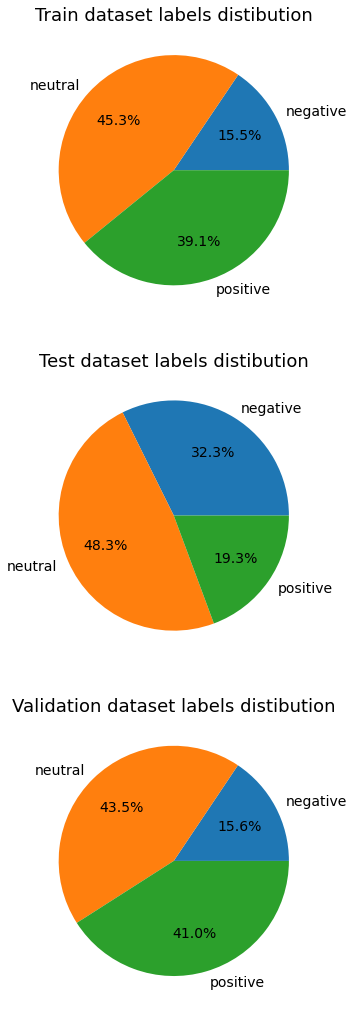

In [80]:
_, axis = plt.subplots(3, 1, figsize=(18,18))
labels_meaning = [
    "negative",
    "neutral",
    "positive"]
for i in range(0,3):
    label, title = labels[i], titles[i]
    label_agg_counts = pd.Series({k:v for k,v in sorted(label.value_counts().items(), key=lambda x: x[0])})
    axis[i].set_title(title, fontsize=18)
    axis[i].pie(
        label_agg_counts,
        autopct='%1.1f%%',
        labels=[labels_meaning[k] for k in label_agg_counts.keys()], 
        pctdistance=0.65, 
        textprops = {"fontsize": 14},
    )


# Я выбрал метрику F1_weighted
Почему я выбрал эту метрику:  
Из всего многообразия метрик правильным кажется выбор f1_weighted метрики, потому что, исходя из описания:
```
'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
```
она подходит для классификации с несбалансированными классами. В нашем случае (см. пайчарты выше) складывается именно такая ситуация - во всех датасетах есть класс, у которого мало представителей. Например для обучающей выборки это класс negative. \
Более того, F1_weighted удобнее использовать в данном случае, потому что в качестве golden тегов у нас имеются лейблы в чистом виде. (для roc-auc, например, понадобилось бы бинаризовать лейблы, и затем было бы сложнее интерпретировать результат)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    

In [107]:
from typing import List, Union
from collections.abc import Iterable
from copy import copy

class DeepAverageNetwork(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 embeddings: np.ndarray,
                 n_classes: int,
                 hidden_dim: int = 128,
                 freeze: bool = True,
                 padding_idx: int = 0
                ):
        super().__init__() 
        assert(len(embeddings.shape) == 2)
        embedding_dim = embeddings.shape[-1]
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.embed.from_pretrained(
               torch.Tensor(embeddings),
               freeze=freeze,
               padding_idx=padding_idx
            )
        # для усреднения
        self.mean_pooling = torch.mean
        # from embeddings  to linear
        linear_layer_1 = nn.Linear(embedding_dim, hidden_dim)        
        # add non-linearity
        relu = nn.ReLU()        
        # from linear to number of classes
        linear_layer_2 = nn.Linear(hidden_dim, n_classes)
        
        self.classifier = nn.Sequential(
            linear_layer_1,
            relu,
            linear_layer_2
        )
        
        # activation
        self.activation = nn.Softmax()
        
    def forward(self, text: torch.Tensor):
        embedded = self.embed(text)        
        mean = self.mean_pooling(embedded, dim=1)
        logits = self.classifier(mean)
        return self.activation(logits)

In [108]:
model = DeepAverageNetwork(
    len(vocab),
    embeddings, # 2-dim матрицы
    len(labels_meaning), # 3
    64
)

In [109]:
model

DeepAverageNetwork(
  (embed): Embedding(100000, 300)
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
  (activation): Softmax(dim=None)
)

## Задайте функцию потерь и оптимизатор

In [110]:
# CEL мне +- знаком, поэтому он
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0005)

model.to(device)
loss_func.to(device)

CrossEntropyLoss()

## Сделайте цикл обучения

#### utils

- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

In [111]:
def train(model, data, opt, loss_func):
    loss_container = []
    ys = {
        "y_hat": [],
        "y_true": []
    }
    model.train()
    
    total = len(data)
    prog_bar = tqdm(enumerate(data), total=total, desc ="DAN training")
    for i, (x, y) in prog_bar:
        text, golden_label = x, y
        opt.zero_grad()   
        
        y_pred = model(text.to(device)).squeeze()     
        
        loss = loss_func(y_pred, golden_label.to(device))          
        loss.backward()
        opt.step()
        
        loss_container.append(loss.item())        
        ys['y_true'].extend(golden_label.tolist()) 
        # load tensor from GPU to CPU, translate to np.array and get indices of max elements - these are the predicted classes
        ys['y_hat'].extend(y_pred.detach().cpu().numpy().argmax(1).tolist())
        
    f1_weighted = f1_score(ys['y_hat'], ys['y_true'], average="weighted")

    return np.mean(loss_container), f1_weighted


In [112]:
def evaluate(model, data, loss_func):
    loss_container = []
    ys = {
        "y_hat": [],
        "y_true": []
    }
    total = len(data)
    prog_bar = tqdm(enumerate(data), total=total, desc ="DAN validation")
    with torch.no_grad():
        for i, (x, y) in prog_bar:
                text, golden_label = x, y
                y_pred = model(text.to(device)).squeeze()     

                loss = loss_func(y_pred, golden_label.to(device))
                loss_container.append(loss.item())

                ys['y_true'].extend(golden_label.tolist())
                ys['y_hat'].extend(y_pred.detach().cpu().numpy().argmax(1).tolist())

    f1_weighted = f1_score(ys['y_hat'], ys['y_true'], average="weighted")

    return np.mean(loss_container), f1_weighted

#### Training

In [113]:
NUM_EPOCHS = 13  # Задайте количество эпох

losses_train = []
losses_eval = []

f1_train = []
f1_eval = []

for n_epoch in range(NUM_EPOCHS):
    print('='*60 + f"\nEpoch {n_epoch}")
    # train
    mean_loss_train, weighted_f1_score_train = train(
        model=model,
        data=train_loader,
        loss_func=loss_func,
        opt=opt
    )
    losses_train.append(mean_loss_train)
    f1_train.append(weighted_f1_score_train)
    # validation
    mean_loss_eval, weighted_f1_score_eval = evaluate(
        model=model,
        data=valid_loader,
        loss_func=loss_func,
    )
    losses_eval.append(mean_loss_eval)
    f1_eval.append(weighted_f1_score_eval)
    
    print(f"Epoch {n_epoch} finished.")
    print(f"Train loss: {mean_loss_train}, Train F1: {weighted_f1_score_train}\n" \
          f"Validation loss: {mean_loss_eval} Validation F1: {weighted_f1_score_eval}\n")

Epoch 0


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 19.78it/s]


Epoch 0 finished.
Train loss: 1.0348874963195631, Train F1: 0.5824986584862805
Validation loss: 1.033930018544197 Validation F1: 0.6047363958106702

Epoch 1


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 19.31it/s]


Epoch 1 finished.
Train loss: 1.02882990157804, Train F1: 0.6007786230970215
Validation loss: 1.0287036299705505 Validation F1: 0.5961411589628501

Epoch 2


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 20.18it/s]


Epoch 2 finished.
Train loss: 1.0193744964439775, Train F1: 0.5909948328975201
Validation loss: 1.0163967832922935 Validation F1: 0.5824317684251801

Epoch 3


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 18.98it/s]


Epoch 3 finished.
Train loss: 1.0018303524182495, Train F1: 0.603191490656611
Validation loss: 1.0032473057508469 Validation F1: 0.587271607508165

Epoch 4


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 19.40it/s]


Epoch 4 finished.
Train loss: 0.9826063959958167, Train F1: 0.6182746774231495
Validation loss: 0.9863572418689728 Validation F1: 0.5932208965284799

Epoch 5


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 20.47it/s]


Epoch 5 finished.
Train loss: 0.967844035039401, Train F1: 0.6241693911700389
Validation loss: 0.9765570163726807 Validation F1: 0.600220140918726

Epoch 6


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 19.36it/s]


Epoch 6 finished.
Train loss: 0.9547092461719193, Train F1: 0.6403541059375968
Validation loss: 0.9696971252560616 Validation F1: 0.6195689485623809

Epoch 7


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 19.62it/s]


Epoch 7 finished.
Train loss: 0.9476971586323317, Train F1: 0.6467859396094899
Validation loss: 0.9692722260951996 Validation F1: 0.6057432783474125

Epoch 8


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 20.19it/s]


Epoch 8 finished.
Train loss: 0.9399237183219228, Train F1: 0.6561343204639969
Validation loss: 0.9597454592585564 Validation F1: 0.6259978885453585

Epoch 9


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 20.93it/s]


Epoch 9 finished.
Train loss: 0.9343329717993071, Train F1: 0.6633250097065359
Validation loss: 0.9561386853456497 Validation F1: 0.63423450744355

Epoch 10


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 20.50it/s]


Epoch 10 finished.
Train loss: 0.9280808521382635, Train F1: 0.6694730213372836
Validation loss: 0.9528511166572571 Validation F1: 0.6374428064019171

Epoch 11


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 17.33it/s]


Epoch 11 finished.
Train loss: 0.9233778538650641, Train F1: 0.6742823205113997
Validation loss: 0.9500886723399162 Validation F1: 0.6338111042472756

Epoch 12


DAN validation: 100%|██████████| 8/8 [00:00<00:00, 20.93it/s]

Epoch 12 finished.
Train loss: 0.9188892225313453, Train F1: 0.6797792031310431
Validation loss: 0.9470267742872238 Validation F1: 0.6392806678700201



#### Testing

По валидации видно, что модель начала немножко переобучаться. Посмотрим на результат, полученный на тестовых данных

Text(0, 0.5, 'Loss')

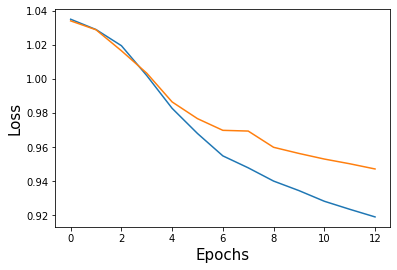

In [114]:
plt.plot(np.arange(len(losses_train)), losses_train, label='Training')
plt.plot(np.arange(len(losses_eval)), losses_eval, label='Validation')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

Text(0, 0.5, 'F1 (weighted)')

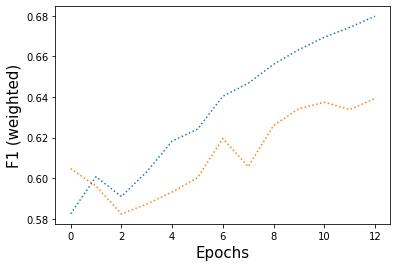

In [115]:
plt.plot(np.arange(len(f1_train)), f1_train, label='Training', ls='dotted')
plt.plot(np.arange(len(f1_eval)), f1_eval, label='Validation', ls='dotted')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('F1 (weighted)', fontsize=15)

In [116]:
# копипаст evaluate, но возвращает другие данные
def get_ys(model, data, loss_func):
    ys = {
        "y_hat": [],
        "y_true": []
    }
    total = len(data)
    with torch.no_grad():
        for (x, y) in data:
                text, golden_label = x, y
                y_pred = model(text.to(device)).squeeze()

                ys['y_true'].extend(golden_label.tolist())
                ys['y_hat'].extend(y_pred.detach().cpu().numpy().argmax(1).tolist())
    return ys['y_hat'], ys['y_true']

In [117]:
from sklearn.metrics import classification_report
y_hat, y_true = get_ys(model, test_loader, loss_func)
print(classification_report(y_true, y_hat))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3972
           1       0.55      0.79      0.65      5937
           2       0.40      0.62      0.48      2375

    accuracy                           0.50     12284
   macro avg       0.31      0.47      0.38     12284
weighted avg       0.34      0.50      0.41     12284



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

Модель обучилась не очень хорошо :(

Что удалось - реализовать простой перцептрон, направленный на мультиклассовую классификацию. Честно говоря, я не уверен, что тело модели реализовано абсолютно верно. Больше всего меня смущает то, что если я не использую `from_pretrained` относительно fasttext эмбеддингов в теле модели, а просто объявляю объект типа torch.nn.Embedding нужной размерности, модель всё равно обучается и обучается **лучше, чем при подаче предобученных эмбеддингов**. Разница в weighted f1 примерно 0,1. Как это вообще происходит?

 Но судя по тому, что на тренировочных данных достаточно быстро снижается loss, модель действительно обучается, но при этом быстро приходит к оверфиттингу относительно тренировочных данных. 

Улучить результат классификации можно было бы:
- Более тщательным тюнингом гиперпараметров (я попробовал 2-3 варианта hidden_size и lr, но не удалось добиться результата хотя бы в районе 0.7 f1-score)
- Усложнение классификатора в модели - добавление дропаута, экспериементы с методами пулинга, увеличение числа линейных слоёв, а лучше даже добавить нелинейные слои.
- и много чего ещё. Поскольку модель совсем базовая, в ней можно улучшчить ещё много чего



